### Continuing the Analysis with NBA.com stats

Here I am augmenting the initial team data collected from Basketball-Reference with similar statistics collected over "clutch" situations from [NBA.com](https://http://stats.nba.com/teams/clutch-four-factors/?sort=W_PCT&dir=-1). These situations are defined as occurring within the last five minutes of regulation or overtime with neither team leading by more than five points.  

In [1]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time

import os
import requests

import pandas as pd
import numpy as np

import re

import nba_dot_com_scrape

Below I first scrape clutch four factors data from the 2001-02 through the 2017-18 seasons. After scraping, I mush everything into one data frame and drop any duplicate columns between the three sets of statistics.

In [2]:
url = 'http://stats.nba.com/teams/clutch-four-factors/?sort=W_PCT&dir=-1&Season=2017-18&SeasonType=Regular%20Season'
dfclutch4fact = nba_dot_com_scrape.scrape_nbacom_tmclutch_by_url(2002, 2018, url)

Now, bring in the data from Basketball-Reference and bind together with the NBA.com data and eventually compute the response variable `diffWP` all over again.

In [3]:
import pickle

In [4]:
with open('bbref_team_all_02_18.pkl', 'rb') as pick:
    df = pickle.load(pick)

In [5]:
df.index = [d.replace('/Oklahoma City', '') for d in df.index]

In [6]:
df = pd.concat([df, dfclutch4fact], axis = 1)

In [7]:
df = df.apply(pd.to_numeric, errors='ignore')
df['WP'] = df['W']/(df['W'] + df['L'])
df['xWP'] = df['PW']/(df['PW'] + df['PL'])
df['diffWP'] = df['WP'] - df['xWP']
df = df[df['W'] >= 30]

In [8]:
df.corr()['diffWP'].sort_values(ascending=False)

diffWP                1.000000
ClutchWIN%            0.550100
ClutchW               0.530375
ClutcheFG%            0.274631
PL                    0.193993
DRtg                  0.188004
Age                   0.139450
W                     0.123274
WP                    0.119896
ClutchMIN             0.118030
ClutchFTA Rate        0.117247
DeFG%                 0.115304
SOS                   0.078686
ClutchGP              0.067121
OTOV%                 0.053519
ClutchOpp TOV%        0.047771
ClutchOREB%           0.045989
DFT/FGA               0.033525
TS%                   0.024953
OeFG%                 0.016740
OFT/FGA               0.003116
Pace                 -0.007224
FTr                  -0.008983
3PAr                 -0.017594
ORtg                 -0.020885
ORB%                 -0.040017
ClutchTOV%           -0.066944
ClutchOpp OREB%      -0.072012
DTOV%                -0.075891
DRB%                 -0.079331
L                    -0.111119
ClutchOpp FTA Rate   -0.170236
SRS     

Here, we begin setting up the dataframes for input into a regression model.

In [9]:
dfeval = df.drop(['W', 'L', 'PW', 'PL', 'WP', 'xWP', 'ClutchW', 'ClutchL', 'ClutchWIN%', 'ClutchGP'], axis=1)
dfeval['Year'] = [int(re.search('\d+$', teamyr).group(0)) for teamyr in dfeval.index]

In [10]:
#dfeval.iloc[:, 18:].corr()
dfeval.shape

(395, 32)

In [11]:
dfeval.rename(columns = lambda x: re.sub('\s', '', x), inplace = True)
dfeval.columns

Index(['Age', 'MOV', 'SOS', 'SRS', 'ORtg', 'DRtg', 'Pace', 'FTr', '3PAr',
       'TS%', 'OeFG%', 'OTOV%', 'ORB%', 'OFT/FGA', 'DeFG%', 'DTOV%', 'DRB%',
       'DFT/FGA', 'Arena', 'Attend.', 'Attend./G', 'diffWP', 'ClutchMIN',
       'ClutcheFG%', 'ClutchFTARate', 'ClutchTOV%', 'ClutchOREB%',
       'ClutchOppeFG%', 'ClutchOppFTARate', 'ClutchOppTOV%', 'ClutchOppOREB%',
       'Year'],
      dtype='object')

In [12]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [13]:
#df_norm['Ones'] = 1
dfeval = dfeval.apply(pd.to_numeric, errors='ignore')
dfeval['Ones'] = np.ones(len(dfeval))
dfeval.columns

Index(['Age', 'MOV', 'SOS', 'SRS', 'ORtg', 'DRtg', 'Pace', 'FTr', '3PAr',
       'TS%', 'OeFG%', 'OTOV%', 'ORB%', 'OFT/FGA', 'DeFG%', 'DTOV%', 'DRB%',
       'DFT/FGA', 'Arena', 'Attend.', 'Attend./G', 'diffWP', 'ClutchMIN',
       'ClutcheFG%', 'ClutchFTARate', 'ClutchTOV%', 'ClutchOREB%',
       'ClutchOppeFG%', 'ClutchOppFTARate', 'ClutchOppTOV%', 'ClutchOppOREB%',
       'Year', 'Ones'],
      dtype='object')

Set up the train, validation and test sets manually, so everything from 2001-02 through 2011-12 are in the training set with the next five seasons are in the validation set (for now) with the test (holdout) set as the last season (2017-18).

In [14]:
#dftrain = df_norm[df_norm['Year'] <= 2017]
dftrain = dfeval[dfeval['Year'] <= 2016]

In [15]:
#dftest = df_norm[df_norm['Year'] > 2017]
#dftest.head()
dftest = dfeval[(dfeval['Year'] > 2016) & (dfeval['Year'] <= 2017)]

In [16]:
dfholdout = dfeval[dfeval['Year'] > 2017]

In [17]:
Ytrain = dftrain['diffWP']
Xtrain = dftrain.drop(['diffWP', 'Year', 'Arena', 'Attend.', 'Attend./G'], axis = 1)
#X = dftrain[['Age', 'ClutchWIN%', 'ClutchMIN', 'ClutcheFG%', 'ClutchFTARate', 'ClutchOREB%', 'ClutchOppeFG%', 'ClutchOppFTARate', 'ClutchOppOREB%', 'ClutchASTRatio']]
#X = dftrain[['ClutchOffRtg', 'ClutchDefRtg']]
#X.dtypes

Let's run an initial model with statsmodels on our training set.

In [18]:
lml = sm.OLS(Ytrain,Xtrain)

In [19]:
fit = lml.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 diffWP   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     8.802
Date:                Thu, 30 Aug 2018   Prob (F-statistic):           2.20e-25
Time:                        10:12:10   Log-Likelihood:                 773.21
No. Observations:                 349   AIC:                            -1490.
Df Residuals:                     321   BIC:                            -1382.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Age                  0.0040      0.001      3.695      0.000       0.002       0.006
MOV                  0.2906      0.292      0.995      0.321      -0.284       0.865
SOS                  0.2849      0.291      0.977      0.329      -0.289       0.858
SRS                 -0.2854      0.292     -0.978      0.329      -0.860       0.289
ORtg                -0.0178      0.015     -1.162      0.246      -0.048       0.012
DRtg                 0.0062      0.014      0.433      0.666      -0.022       0.034
Pace                 0.0009      0.001      1.159      0.247      -0.001       0.002
FTr                  0.2848      0.705      0.404      0.687      -1.103       1.672
3PAr                -0.0040      0.057     -0.071      0.944      -0.117       0.109
TS%                  4.3923      3.362      1.306      0.192      -2.222      11.007
OeFG%               -2.5129      2.843     -0.884      0.377      -8.106       3.080
OTOV%               -0.0117      0.012     -0.960      0.338      -0.036       0.012
ORB%                 0.0056      0.005      1.193      0.234      -0.004       0.015
OFT/FGA             -0.9023      1.448     -0.623      0.534      -3.752       1.947
DeFG%                0.7341      0.936      0.784      0.434      -1.108       2.577
DTOV%               -0.0076      0.009     -0.891      0.374      -0.024       0.009
DRB%                -0.0027      0.003     -0.853      0.394      -0.009       0.004
DFT/FGA              0.2562      0.207      1.235      0.218      -0.152       0.664
ClutchMIN        -2.385e-05   5.78e-05     -0.413      0.680      -0.000    8.99e-05
ClutcheFG%           0.0026      0.000      5.572      0.000       0.002       0.003
ClutchFTARate        0.0501      0.019      2.696      0.007       0.014       0.087
ClutchTOV%          -0.0018      0.001     -2.112      0.036      -0.003      -0.000
ClutchOREB%          0.0011      0.000      2.803      0.005       0.000       0.002
ClutchOppeFG%       -0.0032      0.000     -7.036      0.000      -0.004      -0.002
ClutchOppFTARate    -0.0868      0.019     -4.545      0.000      -0.124      -0.049
ClutchOppTOV%        0.0018      0.001      2.297      0.022       0.000       0.003
ClutchOppOREB%      -0.0013      0.000     -3.219      0.001      -0.002      -0.001
Ones                 0.0107      0.653      0.016      0.987      -1.273       1.294
==============================================================================
Omnibus:                        1.120   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.571   Jarque-Bera (JB):                1.215
Skew:                           0.125   Prob(JB):                        0.545
Kurtosis:                       2.856   Cond. No.                     8.42e+05
=====================================================

The training $R^2$ looks OK, and it appears as if the significant features include `Age` (the average age of a team, which can describe experience) and those related to a team's margin of victory, both over entire games and in the clutch. Interestingly, clutch per-possesion assists and rebounding appear to also be significant features.

Let's first take a look at model adequacy and then examine test set performance.

In [20]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

(array([ 7., 21., 40., 73., 85., 56., 39., 22.,  4.,  2.]),
 array([-0.06876031, -0.05333122, -0.03790214, -0.02247306, -0.00704398,
         0.0083851 ,  0.02381418,  0.03924326,  0.05467234,  0.07010142,
         0.08553051]),
 <a list of 10 Patch objects>)

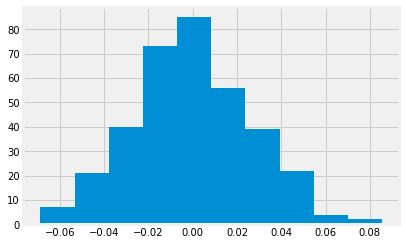

In [21]:
yhat = fit.predict(Xtrain)
res = Ytrain-yhat
plt.hist(res)

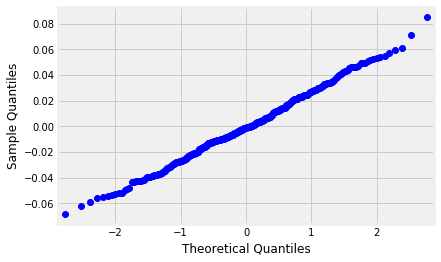

In [22]:
sm.qqplot(res)
plt.show()

([], <a list of 0 Text xticklabel objects>)

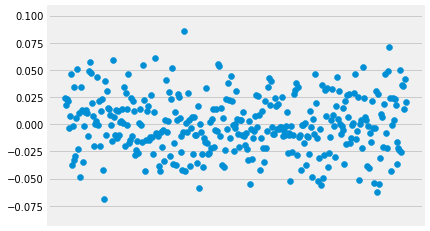

In [23]:
plt.scatter(Xtrain.index, res)
plt.xticks([])

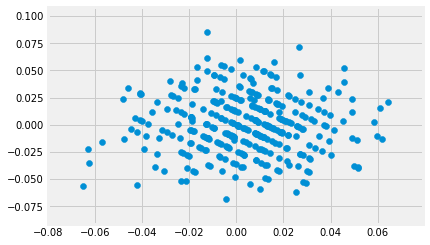

In [24]:
plt.scatter(yhat, res)

Everything looks OK -- the residuals look normally distributed enough, of relatively constant variance, and not autocorrelated.

In [25]:
Ytest = dftest['diffWP']
Xtest = dftest.drop(['diffWP', 'Year', 'Arena', 'Attend.', 'Attend./G'], axis = 1)
Yhat_test = fit.predict(Xtest)

In [26]:
sqerr = (Ytest-Yhat_test)**2

In [27]:
sqtot = (Ytest-Ytest.mean())**2

In [28]:
#r2adj = (sum(sqerr)/(len(Xtest) - len(fit.params) - 1))/(sum(sqtot)/(len(Xtest)-1))
rsqtest = 1-(sum(sqerr)/sum(sqtot))
print(rsqtest)

0.2908769620300615


The test $R^2$ is lower than the train $R^2$. Overfitting might be an issue here, let's see what happens with some feature selection and regularization.

In [29]:
from sklearn import preprocessing, linear_model, pipeline, model_selection, feature_selection, metrics

In [30]:
select_pipe = pipeline.Pipeline(
    [("std", preprocessing.StandardScaler()),
    ("select",
      feature_selection.SelectKBest(
          score_func=feature_selection.f_regression, k=3)),
     ("ols", linear_model.LinearRegression())])
select_pipe.get_params()

{'memory': None,
 'ols': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
 'ols__copy_X': True,
 'ols__fit_intercept': True,
 'ols__n_jobs': 1,
 'ols__normalize': False,
 'select': SelectKBest(k=3, score_func=<function f_regression at 0x1c1fe469d8>),
 'select__k': 3,
 'select__score_func': <function sklearn.feature_selection.univariate_selection.f_regression>,
 'std': StandardScaler(copy=True, with_mean=True, with_std=True),
 'std__copy': True,
 'std__with_mean': True,
 'std__with_std': True,
 'steps': [('std', StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('select',
   SelectKBest(k=3, score_func=<function f_regression at 0x1c1fe469d8>)),
  ('ols',
   LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]}

In [34]:
X = dftrain
Xtrain.head()

,Age,MOV,SOS,SRS,ORtg,DRtg,Pace,FTr,3PAr,TS%,...,ClutchMIN,ClutcheFG%,ClutchFTARate,ClutchTOV%,ClutchOREB%,ClutchOppeFG%,ClutchOppFTARate,ClutchOppTOV%,ClutchOppOREB%,Ones
Atlanta Hawks 2002,25.7,-4.23,-0.18,-4.41,101.8,106.4,91.9,0.294,0.181,0.517,...,177,45.8,0.647,15.3,22.6,43.4,0.529,11.2,28.9,1.0
Atlanta Hawks 2003,27.2,-3.56,-0.31,-3.87,102.3,106.1,91.0,0.313,0.177,0.527,...,180,47.3,0.534,14.5,25.5,45.2,0.470,13.1,30.1,1.0
Atlanta Hawks 2007,24.1,-4.76,-0.10,-4.86,103.0,108.3,90.0,0.346,0.163,0.523,...,160,44.5,0.477,12.2,30.3,47.3,0.556,13.9,36.0,1.0
Atlanta Hawks 2008,24.2,-1.82,-0.41,-2.23,106.9,108.9,91.1,0.340,0.165,0.535,...,178,39.0,0.653,14.9,33.3,46.7,0.539,12.5,35.2,1.0
Atlanta Hawks 2009,25.8,1.57,0.13,1.70,109.3,107.6,89.6,0.323,0.253,0.546,...,158,51.1,0.548,11.3,26.1,43.9,0.576,19.0,28.1,1.0


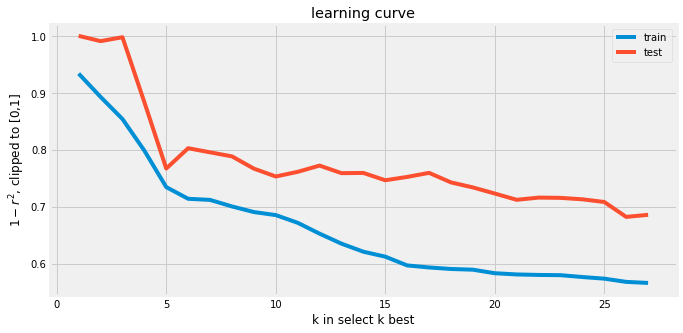

In [54]:
plt.figure(figsize=(10,5))
train_scores = []
test_scores = []
num_fs = range(1, len(Xtrain.columns), 1)
for i, num_f in enumerate(num_fs):
    select_pipe.set_params(select__k=num_f)
    train_splits = []
    test_splits = []
    for yr in range(2012, 2017):
        dftrain = dfeval[dfeval['Year'] <= yr]
        dftest = dfeval[(dfeval['Year'] > yr) & (dfeval['Year'] <= 2017)]
        
        Y = dftrain['diffWP']
        X = dftrain.drop(['diffWP', 'Year', 'Arena', 'Attend.', 'Attend./G'], axis = 1)
        Ytest = dftest['diffWP']
        Xtest = dftest.drop(['diffWP', 'Year', 'Arena', 'Attend.', 'Attend./G'], axis = 1)
        
        fit = select_pipe.fit(X.drop('Ones', axis=1), Y)
        train_splits.append(fit.score(X.drop('Ones', axis=1), Y))
        test_splits.append(fit.score(Xtest.drop('Ones', axis=1), Ytest))
        
    train_scores.append(np.mean(train_splits))
    test_scores.append(np.mean(test_splits))

plt.plot(num_fs, 1 - np.array(train_scores), label="train")
plt.plot(num_fs, 1 - np.maximum(test_scores, 0), label="test")
plt.xlabel("k in select k best")
plt.ylabel("$1-r^2$, clipped to [0,1]")
plt.title("learning curve")
plt.legend()

In [69]:
select_pipe.set_params(select__k=5)
k_best_fit = select_pipe.fit(X.drop('Ones', axis=1),Y)
features = select_pipe.named_steps['select']
feat = X.drop('Ones', axis=1).columns[features.get_support()]

In [70]:
k_best_fit.score(X.drop('Ones', axis=1), Y)

0.2693280040976874

In [71]:
k_best_fit.score(Xtest.drop('Ones', axis=1), Ytest)

0.18293985028486326

In [72]:
Yholdout = dfholdout['diffWP']
Xholdout = dfholdout.drop(['diffWP', 'Year', 'Arena', 'Attend.', 'Attend./G'], axis = 1)

In [73]:
k_best_fit.score(Xholdout.drop('Ones', axis=1), Yholdout)

0.2573830662762553

In [74]:
coefs = list(zip(list(feat), select_pipe.named_steps["ols"].coef_))

([<matplotlib.axis.YTick at 0x1c287346d8>,
 <a list of 5 Text yticklabel objects>)

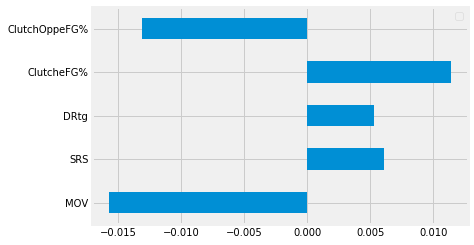

In [75]:
coefs_df = pd.DataFrame.from_records(coefs)
coefs_df.plot.barh()
plt.legend([])
plt.yticks(range(0, len(coefs_df)), coefs_df[0])

OK this looks more reasonable, even if neither train nor test nor holdout $R^2$ is high  and the selected features set seems not to have resolved collinearity issues too much. For interpretability, the especially large coefficients for margin of victory `MOV` and the simple rating system `SRS` don't seem to make a great model either. It's interesting that `DRtg` is included amongst these features . The three clutch features included do make sense, however.

Let us see if there are any improvements to be found using Ridge regression.

In [35]:
ridge_pipe = pipeline.Pipeline([
     ("std", preprocessing.StandardScaler()),
     ("var", feature_selection.VarianceThreshold()), 
     ("ridge", linear_model.Ridge())
    ])

In [36]:
# alphas look best when logspaced
alphas = np.logspace(5, .5, num=50)
coefs = []
train_scores = []
test_scores = []
preds = []
fits = []

# loop through each of the 50 alphas
for i, alpha in enumerate(alphas):
    # set the alpha for our pipeline
    ridge_pipe.set_params(ridge__alpha=alpha)
    
    train_splits = []
    test_splits = []
    
    for yr in range(2012, 2017):
        dftrain = dfeval[dfeval['Year'] <= yr]
        dftest = dfeval[(dfeval['Year'] > yr) & (dfeval['Year'] <= 2017)]
        
        Y = dftrain['diffWP']
        X = dftrain.drop(['diffWP', 'Year', 'Arena', 'Attend.', 'Attend./G'], axis = 1)
        Ytest = dftest['diffWP']
        Xtest = dftest.drop(['diffWP', 'Year', 'Arena', 'Attend.', 'Attend./G'], axis = 1)
        
        fit = ridge_pipe.fit(X.drop('Ones', axis=1), Y)
        train_splits.append(fit.score(X.drop('Ones', axis=1), Y))
        test_splits.append(fit.score(Xtest.drop('Ones', axis=1), Ytest))
        
    train_scores.append(np.mean(train_splits))
    test_scores.append(np.mean(test_splits))
    
    fit_train = ridge_pipe.fit(Xtrain.drop('Ones', axis=1), Ytrain)
    fits.append(fit_train)
    preds.append(fit_train.predict(Xtrain.drop('Ones', axis=1)))
    coefs.append(ridge_pipe.named_steps["ridge"].coef_)

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


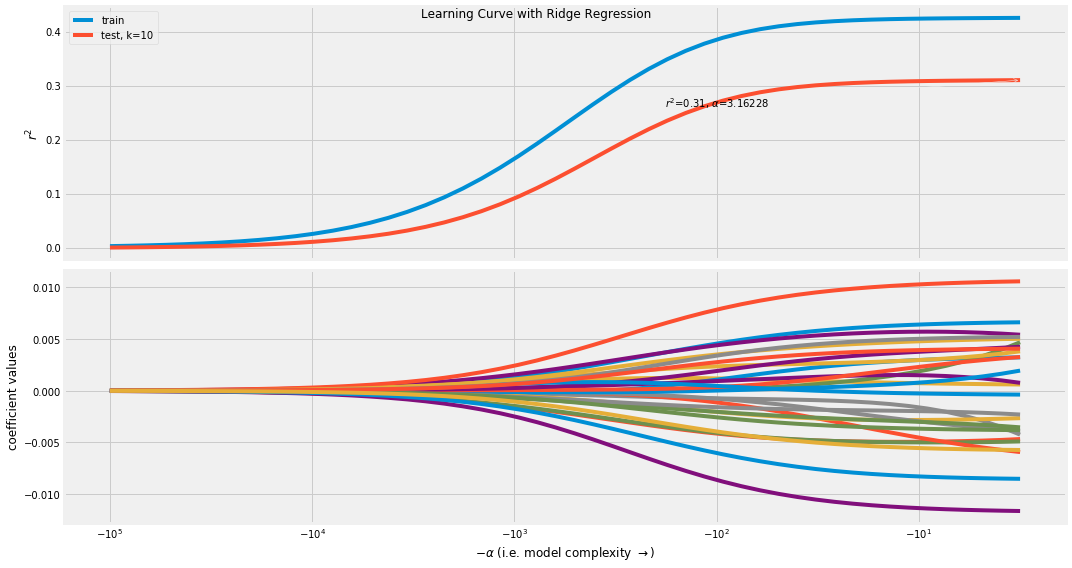

In [37]:
# set up the figure. I'll do the learning curve above and coefficient path below
fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True, tight_layout=True)
# list of arrays -> single array
coef_arr = np.squeeze(coefs, axis=1)
# grab the first axis
ax0 = axes.flat[0]
# plot train and test curves
ax0.plot(-alphas, train_scores, label="train")
ax0.plot(-alphas, test_scores, label="test, k=10")
# find the index of the best score
best_i = np.argmax(test_scores)
# annotate score
ann_xy = (-alphas[best_i], test_scores[best_i])
ann_text = f"$r^2$={test_scores[best_i]:.2}, $\\alpha$={alphas[best_i]:g}"
ax0.annotate(ann_text, xy=ann_xy, xytext=(.6,.6), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->"),
            )
ax0.set_ylabel("$r^2$")
ax0.legend()

# grab the second axis
ax1 = axes.flat[1]
ax1.plot(-alphas, coef_arr)
ax1.set_ylabel("coefficient values")
ax1.set_xlabel("$-\\alpha$ (i.e. model complexity $\\rightarrow$)")
fig.suptitle("Learning Curve with Ridge Regression")
plt.xscale("symlog")

Let's first look at model adequacy for the best ridge fit. First get and look at the residuals.

In [38]:
res_ridge = Y-preds[best_i]

(array([10., 25., 42., 72., 82., 52., 40., 22.,  2.,  2.]),
 array([-0.06530122, -0.05030022, -0.03529923, -0.02029823, -0.00529723,
         0.00970376,  0.02470476,  0.03970576,  0.05470675,  0.06970775,
         0.08470875]),
 <a list of 10 Patch objects>)

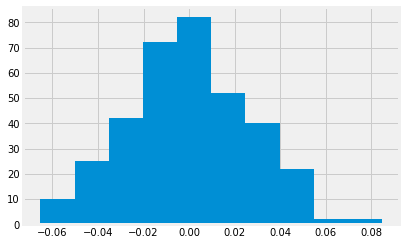

In [39]:
plt.hist(res_ridge)

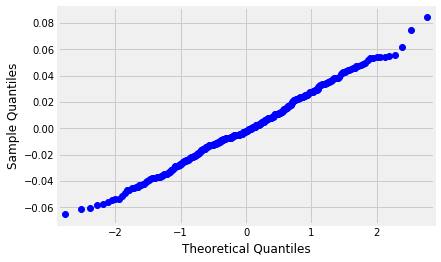

In [40]:
sm.qqplot(res_ridge)
plt.show()

([], <a list of 0 Text xticklabel objects>)

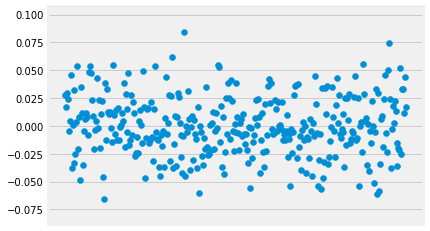

In [41]:
plt.scatter(X.index, res_ridge)
plt.xticks([])

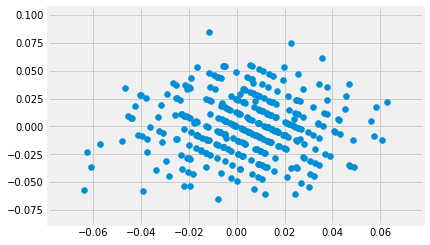

In [42]:
plt.scatter(preds[best_i], res_ridge)

Everything seems to check out from the above. Now let's look at the coefficients.

In [43]:
coefs[best_i]

array([ 0.00662248, -0.00467702,  0.00060254, -0.00490842, -0.00425318,
        0.00541918,  0.00322671, -0.00593673, -0.00265564,  0.00469068,
       -0.0039229 ,  0.00076356,  0.00194578,  0.00326141,  0.00381347,
       -0.00354352, -0.00230391,  0.0042554 , -0.0003755 ,  0.01058609,
        0.00502742, -0.00381256,  0.00520693, -0.01164261, -0.0085262 ,
        0.00407103, -0.00573773])

In [44]:
coefs_sort = sorted(list(zip(Xtrain.columns, coefs[best_i])), key=lambda t: abs(t[1]), reverse=True)[:10]

([<matplotlib.axis.YTick at 0x1c25505e80>,
 <a list of 10 Text yticklabel objects>)

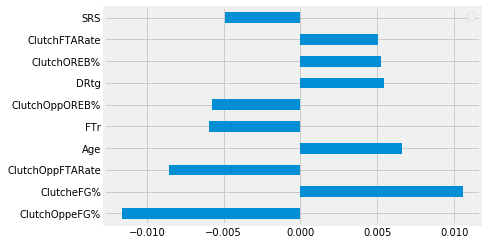

In [45]:
coef_df = pd.DataFrame.from_records(coefs_sort)
coef_df.plot.barh()
plt.legend([])
plt.yticks(range(0, len(coef_df)), coef_df[0])

In [48]:
Xholdout.columns

Index(['Age', 'MOV', 'SOS', 'SRS', 'ORtg', 'DRtg', 'Pace', 'FTr', '3PAr',
       'TS%', 'OeFG%', 'OTOV%', 'ORB%', 'OFT/FGA', 'DeFG%', 'DTOV%', 'DRB%',
       'DFT/FGA', 'ClutchMIN', 'ClutcheFG%', 'ClutchFTARate', 'ClutchTOV%',
       'ClutchOREB%', 'ClutchOppeFG%', 'ClutchOppFTARate', 'ClutchOppTOV%',
       'ClutchOppOREB%', 'Ones'],
      dtype='object')

In [49]:
best_fit = fits[best_i]
best_fit.score(Xholdout.drop('Ones', axis=1), Yholdout)

0.26757115871309733

Test $R^2$ has improved slightly, and the more important features (at least by coefficient absolute value) appear more sensible in the context of what happens on the court.

The above plot suggests some conclusions one might expect:

* It's really important to shoot well (`ClutcheFG%` +), get to the line (`ClutchFTARate` +) and to retain possession of the ball (`ClutchOREB%` +) in clutch situations.
* Likewise, it's also really important to prevent one's opponent from shooting well, getting to the line or retaining possesion of the ball in clutch situations (`ClutchOppOREB%`-), (`ClutchOppFTARate` -), and (`ClutchOppeFG%` -).
* Experience, as expressed through the average age `Age`, also has a positive (negative) relationship with overperformance (underperformance).
* The average margin of victory `SRS` is actually negatively related to `diffWP`, which makes some sense as teams who perform somewhat poorly in this metric would tend to overachieve while those with the opposite would tend to underachieve.
* Similarly, defensive rating `DRtg`, a measure of points a team allows per 100 possesions, has a positive realtionship with `diffWP`, that is, teams that overall are defensively efficient underachieve compared to less efficient defenses. This seems odd and counterintuitive but may point to an idea that teams that are primarily good at defending can't rely on it during clutch situations and don't necessarily have the scoring prowess in those situations to essentially help out their generally high-level defense.
* The presence of general free-throw rate (all situations) `FTr`, and with a negative coefficient value, is a bit confusing -- perhaps it is similar to the presence of `DRtg`.

### Exploration with Lasso

In [50]:
lasso_pipe = pipeline.Pipeline([
     ("std", preprocessing.StandardScaler()),
     ("lasso", linear_model.Lasso())
    ])

In [51]:
# alphas look best when logspaced
alphas = np.logspace(-4, -2, num=50)
coefs = []
train_scores = []
test_scores = []

# loop through each of the 50 alphas
for i, alpha in enumerate(alphas):
    # set the alpha for our pipeline
    lasso_pipe.set_params(lasso__alpha=alpha)
    
    train_splits = []
    test_splits = []
    
    for yr in range(2012, 2017):
        dftrain = dfeval[dfeval['Year'] <= yr]
        dftest = dfeval[(dfeval['Year'] > yr) & (dfeval['Year'] <= 2017)]
        
        Y = dftrain['diffWP']
        X = dftrain.drop(['diffWP', 'Year', 'Arena', 'Attend.', 'Attend./G'], axis = 1)
        Ytest = dftest['diffWP']
        Xtest = dftest.drop(['diffWP', 'Year', 'Arena', 'Attend.', 'Attend./G'], axis = 1)
        
        fit = lasso_pipe.fit(X.drop('Ones', axis=1), Y)
        train_splits.append(fit.score(X.drop('Ones', axis=1), Y))
        test_splits.append(fit.score(Xtest.drop('Ones', axis=1), Ytest))
        
    train_scores.append(np.mean(train_splits))
    test_scores.append(np.mean(test_splits))
    
    fit_train = lasso_pipe.fit(Xtrain.drop('Ones', axis=1), Ytrain)
    fits.append(fit_train)
    preds.append(fit_train.predict(Xtrain.drop('Ones', axis=1)))
    coefs.append(lasso_pipe.named_steps["lasso"].coef_)

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


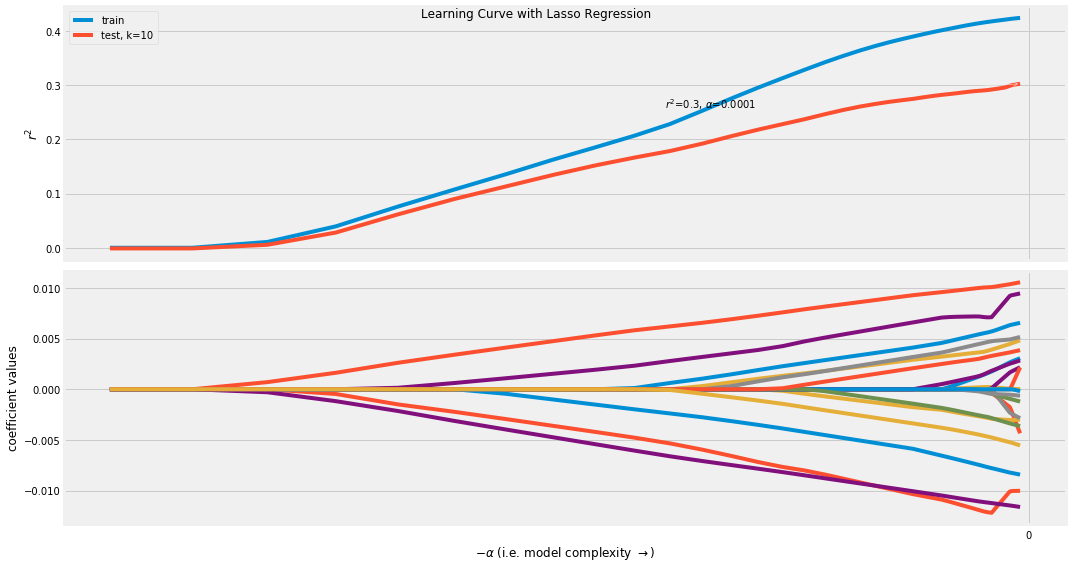

In [52]:
# set up the figure. I'll do the learning curve above and coefficient path below
fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True, tight_layout=True)
# list of arrays -> single array
coef_arr = np.squeeze(coefs, axis=1)
# grab the first axis
ax0 = axes.flat[0]
# plot train and test curves
ax0.plot(-alphas, train_scores, label="train")
ax0.plot(-alphas, test_scores, label="test, k=10")
# find the index of the best score
best_i = np.argmax(test_scores)
# annotate score
ann_xy = (-alphas[best_i], test_scores[best_i])
ann_text = f"$r^2$={test_scores[best_i]:.2}, $\\alpha$={alphas[best_i]:g}"
ax0.annotate(ann_text, xy=ann_xy, xytext=(.6,.6), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->"),
            )
ax0.set_ylabel("$r^2$")
ax0.legend()

# grab the second axis
ax1 = axes.flat[1]
ax1.plot(-alphas, coef_arr)
ax1.set_ylabel("coefficient values")
ax1.set_xlabel("$-\\alpha$ (i.e. model complexity $\\rightarrow$)")
fig.suptitle("Learning Curve with Lasso Regression")
plt.xscale("symlog")

In [53]:
sorted(list(zip(Xtrain.columns, coefs[best_i])), key=lambda t: abs(t[1]), reverse=True)

[('ClutchOppeFG%', -0.011607719873897667),
 ('ClutcheFG%', 0.010547490140271686),
 ('MOV', -0.010013200311509906),
 ('DRtg', 0.009446973150246877),
 ('ClutchOppFTARate', -0.00841609757473271),
 ('Age', 0.006549657445488383),
 ('ClutchOppOREB%', -0.005534866826647491),
 ('ClutchOREB%', 0.0051523982251814775),
 ('ClutchFTARate', 0.00482206456719156),
 ('FTr', -0.00434319615972073),
 ('ClutchOppTOV%', 0.003856709983219191),
 ('ClutchTOV%', -0.0036327045975575105),
 ('Pace', 0.0030611146284748015),
 ('3PAr', -0.00300540400372998),
 ('OeFG%', -0.002852399073020383),
 ('DFT/FGA', 0.0028401124025553707),
 ('OTOV%', 0.002166720696072321),
 ('OFT/FGA', 0.0021516941365525527),
 ('DTOV%', -0.0012103389826000188),
 ('DRB%', -0.000637117575020715),
 ('ClutchMIN', -0.00018487471274056808),
 ('SOS', 1.610523968949541e-05),
 ('SRS', -0.0),
 ('ORtg', -0.0),
 ('TS%', 0.0),
 ('ORB%', 0.0),
 ('DeFG%', 0.0)]